# **Acetaminophen Attenuates Perception of Auditory Stimuli**
# ***INDUCED EMOTION DATA***

# **Goal 1: Long Form Analysis**
The initial Qualtrics data was pre-processed in a separate R script. For this part of the analysis, we will build on those dataframes and perform the following tasks:
1. Examination of Missing Data
2. Checking for Duplicates
3. Adding High-Level Summary Features
4. Looking at Mean Differences between Drug and Placebo
    * Overall means
    * Stimulus type (music, natural sounds, and speech)
    * Emotion type (positive, negative, neutral)
    * Arousal and valence levels
    
**We will do this separately for *induced* emotion data and *perceived* emotion data**

In [27]:
# basic coding/ML tools
import numpy as np, pandas as pd, os, sys, scipy, xlrd, urllib, itertools, re, warnings
from jupyter_contrib_nbextensions.application import main
from ipywidgets import interact
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.stats import ttest_ind

# ML tools
import sklearn, statsmodels.api as sm, statsmodels.formula.api as smf, pingouin as pg
from statsmodels.stats.anova import AnovaRM
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing, metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report, multilabel_confusion_matrix

# visualization tools
import matplotlib.pyplot as plt, seaborn as sns, IPython.display
from statsmodels.graphics.factorplots import interaction_plot
from IPython.display import Image, HTML
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)

# set directory
os.chdir("/Users/home/Desktop/Research/Tylenol/Analysis")

# only get warnings once
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%run Acetaminophen_Functions.ipynb

In [28]:
inducedLong = pd.read_csv('cleaned_inducedLong.csv')

### Comparing Means Between Drug/Placebo

In [29]:
# Change values for easy interpretation
inducedLong['DrugPlacebo'].replace(0, "Placebo", inplace=True)
inducedLong['DrugPlacebo'].replace(1, "Drug", inplace=True)

# Make arrays for t-tests
placebo = inducedLong[inducedLong['DrugPlacebo']=="Placebo"]
drug = inducedLong[inducedLong['DrugPlacebo']=="Drug"]

In [30]:
pos = inducedLong.drop(columns=['Negative']).reset_index(drop=True)
pos.rename(columns={'Positive':'Rating'},inplace=True)

neg = inducedLong.drop(columns=['Positive']).reset_index(drop=True)
neg.rename(columns={'Negative':'Rating'},inplace=True)
induced = pos.append(neg, ignore_index=True)
induced.dropna(subset=['Rating'], inplace=True)

print("Mean Ratings of Stimuli by Drug/Placebo Condition")
induced.groupby(['DrugPlacebo'])['Rating'].agg(['mean', 'std']).round(3)

Mean Ratings of Stimuli by Drug/Placebo Condition


,mean,std
DrugPlacebo,,
Drug,3.643,3.398
Placebo,3.641,3.379


In [31]:
mixed_model = smf.mixedlm("Rating ~ DrugPlacebo", induced, groups="FixedID")
mixed_model_results = mixed_model.fit()
mixed_model_results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:                MixedLM   Dependent Variable:   Rating     
No. Observations:     8476      Method:               REML       
No. Groups:           237       Scale:                10.7473    
Min. group size:      2         Log-Likelihood:       -22239.4901
Max. group size:      36        Converged:            Yes        
Mean group size:      35.8                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.643    0.093 39.156 0.000  3.460  3.825
DrugPlacebo[T.Placebo] -0.001    0.133 -0.006 0.995 -0.261  0.259
FixedID Var             0.740    0.030                           
=================================================================

"""

## Positive and Negative Analysis

#### *Overall Means*
We examine the overall mean scores for *positive emotion ratings*, *negative emotion ratings*, and *arousal ratings* for participants who took the drug vs. participants who took the placebo.

**We then compare the means using t-tests.**

In [4]:
print("Mean Ratings of Pos/Neg Stimuli")
print("Positive mean:", "%.3f" % inducedLong['Positive'].mean(), "std dev:", "%.3f" % inducedLong['Positive'].std())
print("Negative mean:", "%.3f" % inducedLong['Negative'].mean(), "std dev:", "%.3f" % inducedLong['Negative'].std())

Mean Ratings of Pos/Neg Stimuli
Positive mean: 3.679 std dev: 3.411
Negative mean: 3.605 std dev: 3.366


In [5]:
# Positive Emotion Ratings
positive = inducedLong[['FixedID', 'DrugPlacebo', 'Positive']]
positive = positive[positive['Positive'].notna()]

print("Induced Emotion Overall Means -- Positive")
positive.groupby(['DrugPlacebo'])['Positive'].agg(['mean', 'std']).round(3)

# mixed_model = smf.mixedlm("Positive ~ DrugPlacebo", positive, groups="FixedID")
# mixed_model_results = mixed_model.fit()
# print(mixed_model_results.summary())

Induced Emotion Overall Means -- Positive


,mean,std
DrugPlacebo,,
Drug,3.641,3.410
Placebo,3.718,3.412


In [6]:
# Negative Emotion Ratings
negative = inducedLong[['FixedID', 'DrugPlacebo', 'Negative']]
negative = negative[negative['Negative'].notna()]

print("Induced Emotion Overall Means -- Negative")
negative.groupby(['DrugPlacebo'])['Negative'].agg(['mean', 'std']).round(3)

# mixed_model = smf.mixedlm("Negative ~ DrugPlacebo", negative, groups="FixedID")
# mixed_model_results = mixed_model.fit()
# print(mixed_model_results.summary())

Induced Emotion Overall Means -- Negative


,mean,std
DrugPlacebo,,
Drug,3.644,3.386
Placebo,3.564,3.345


#### **Conclusion: There is no difference in induced emotion ratings for positive emotions or negative emotions between drug and placebo conditions.**


# *Stimulus Type (Music, Natural Sounds)*
Although there were no differences in the overall means between drug and placebo conditions, we will look at the mean induced emotion ratings across different stimulus types.

We will *not* conduct t-tests to prevent any potential problems of multiple tests.

### There are no speech stimuli for induced emotion

In [7]:
# Positive Emotion Ratings
print("Induced Emotion Stimulus Type -- Positive")
inducedLong.groupby(['DrugPlacebo', 'SoundType'])['Positive'].agg(['mean', 'std']).round(3)

Induced Emotion Stimulus Type -- Positive


mean    std
DrugPlacebo SoundType                   
Drug        Music           4.718  3.218
            Natural Sounds  2.780  3.315
Placebo     Music           4.568  3.276
            Natural Sounds  3.041  3.368

In [8]:
# Negative Emotion Ratings
print("Induced Emotion Stimulus Type -- Negative")
inducedLong.groupby(['DrugPlacebo', 'SoundType'])['Negative'].agg(['mean', 'std']).round(3)

Induced Emotion Stimulus Type -- Negative


mean    std
DrugPlacebo SoundType                   
Drug        Music           3.144  3.067
            Natural Sounds  4.045  3.572
Placebo     Music           3.156  3.090
            Natural Sounds  3.888  3.502

#### *Graph Stimulus Type:* **Positive**

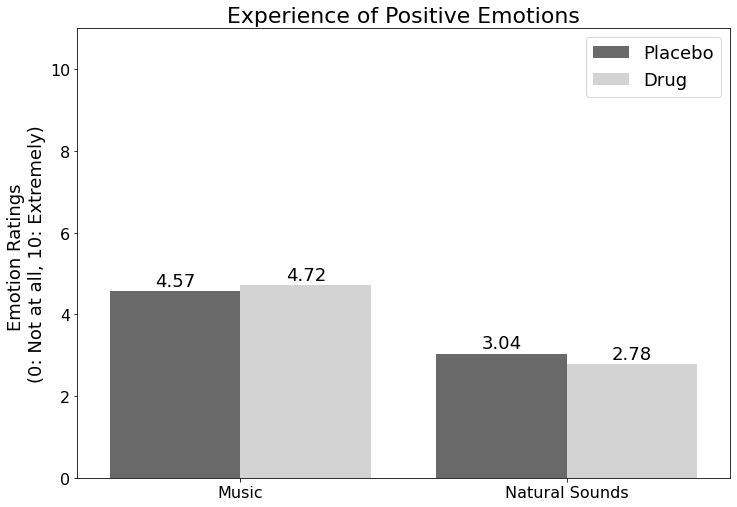

In [9]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Positive", hue="DrugPlacebo", data=inducedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

#### *Graph Stimulus Type:* **Negative**
Now we can look at the attentuating effect of acetaminophen on perceived negative emotions.

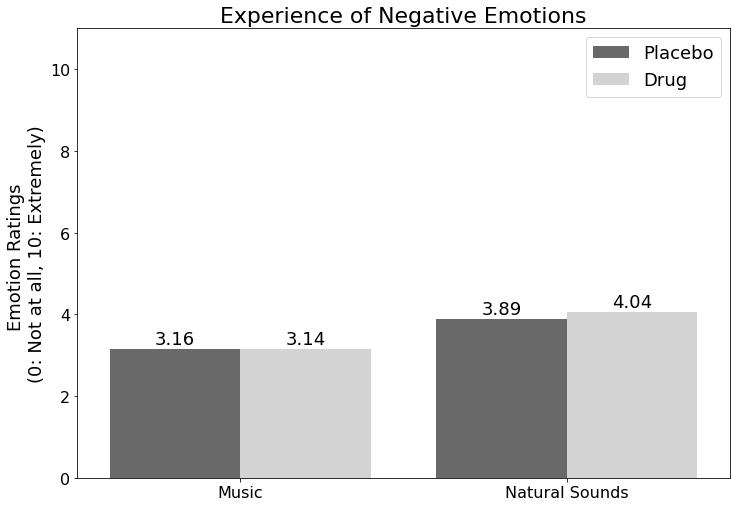

In [10]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="SoundType", y="Negative", hue="DrugPlacebo", data=inducedLong, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

### There are no arousal ratings for induced emotion

# *Emotion Type (Positive, Negative, Neutral)*
Next, we will look at the induced emotion ratings for positive stimuli, negative stimuli, and netural stimuli in both drug and placebo conditions.

In [11]:
# # Positive Emotion Ratings
# print("Induced Emotion Emotion Type -- Positive")
# print(inducedLong.groupby(['DrugPlacebo', 'PosNeg'])['Positive'].agg(['mean', 'std']).round(3), "\n")

# # Negative Emotion Ratings
# print("Induced Emotion Emotion Type -- Negative")
# print(inducedLong.groupby(['DrugPlacebo', 'PosNeg'])['Negative'].agg(['mean', 'std']).round(3))

## *Circumplex Type (Arousal and Valence Info)*
We can look to see whether the drug attenuation affects perceived emotion ratings for different types of emotional stimuli:
* Negative Valence, High Arousal
* Negative Valence, Low Arousal
* Neutral
* Positive Valence, Low Arousal
* Positive Valence, High Arousal


In [12]:
# Positive Emotion Ratings
print("Induced Emotion Circumplex -- Positive")
inducedLong.groupby(['DrugPlacebo', 'Russell'])['Positive'].agg(['mean', 'std']).round(3)

Induced Emotion Circumplex -- Positive


mean    std
DrugPlacebo Russell                               
Drug        Neg-Valence High-Arousal  1.431  2.117
            Neg-Valence Low-Arousal   1.862  2.424
            Neutral                   1.292  1.976
            Pos-Valence High-Arousal  6.844  2.558
            Pos-Valence Low-Arousal   5.602  2.934
Placebo     Neg-Valence High-Arousal  1.561  2.396
            Neg-Valence Low-Arousal   1.968  2.439
            Neutral                   1.524  2.081
            Pos-Valence High-Arousal  6.900  2.517
            Pos-Valence Low-Arousal   5.561  2.937

In [13]:
# Negative Emotion Ratings
print("Induced Emotion Circumplex -- Negative")    
inducedLong.groupby(['DrugPlacebo', 'Russell'])['Negative'].agg(['mean', 'std']).round(3)

Induced Emotion Circumplex -- Negative


mean    std
DrugPlacebo Russell                               
Drug        Neg-Valence High-Arousal  6.410  2.965
            Neg-Valence Low-Arousal   5.358  3.008
            Neutral                   3.854  3.098
            Pos-Valence High-Arousal  1.046  1.720
            Pos-Valence Low-Arousal   1.658  2.176
Placebo     Neg-Valence High-Arousal  6.271  2.939
            Neg-Valence Low-Arousal   5.296  3.017
            Neutral                   3.602  3.106
            Pos-Valence High-Arousal  0.987  1.682
            Pos-Valence Low-Arousal   1.667  2.102

#### *Graph Circumplex:* **Positive**
Once again, a graph will help visualize this effect.

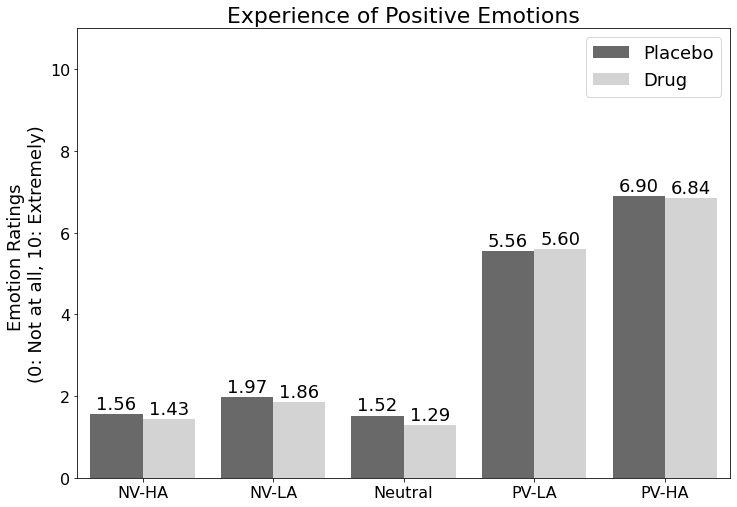

In [14]:
# change labels for easy interpretation
inducedLong['Russell'].replace("Neg-Valence High-Arousal", "NV-HA", inplace=True)
inducedLong['Russell'].replace("Pos-Valence High-Arousal", "PV-HA", inplace=True)
inducedLong['Russell'].replace("Neg-Valence Low-Arousal", "NV-LA", inplace=True)
inducedLong['Russell'].replace("Pos-Valence Low-Arousal", "PV-LA", inplace=True)

# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Positive", hue="DrugPlacebo", data=inducedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

#### *Graph Circumplex:* **Negative**
And our last graph.

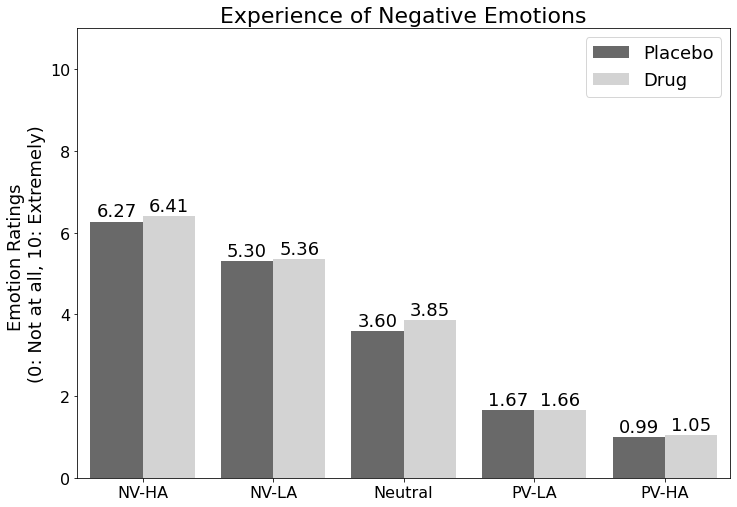

In [15]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Russell", y="Negative", hue="DrugPlacebo", data=inducedLong, 
                 palette=colors, ci = None, order = ['NV-HA', 'NV-LA', 'Neutral', 'PV-LA', 'PV-HA'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

# **Plot perceived emotions by sound type**

In [16]:
music = inducedLong[inducedLong['SoundType'] == "Music"]
natural = inducedLong[inducedLong['SoundType'] == "Natural Sounds"]
speech = inducedLong[inducedLong['SoundType'] == "Speech"]

## *Music*

In [17]:
musicEmotions = [
    (music['Stimulus'].str.contains('Tender', regex=True) == True),
    (music['Stimulus'].str.contains('Sad', regex=True) == True),
    (music['Stimulus'].str.contains('Happy', regex=True) == True),
    (music['Stimulus'].str.contains('Fear', regex=True) == True)]
choices = ['Tender', 'Sad', 'Happy', 'Fear']
music['Stimulus'] = np.select(musicEmotions, choices)

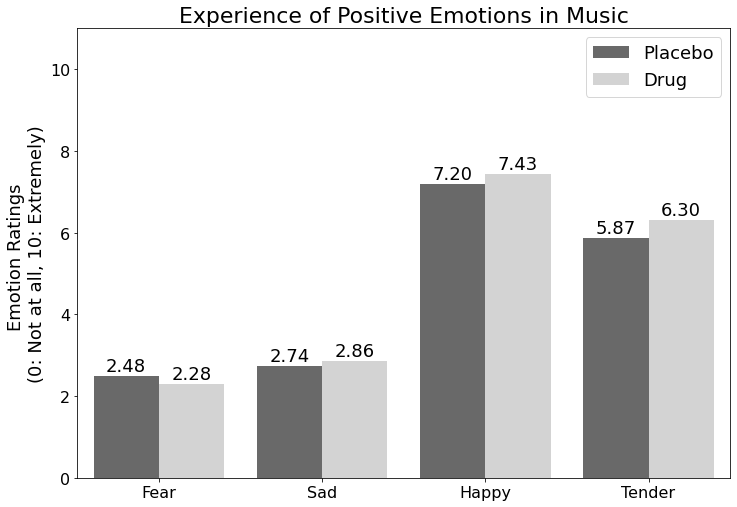

In [18]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

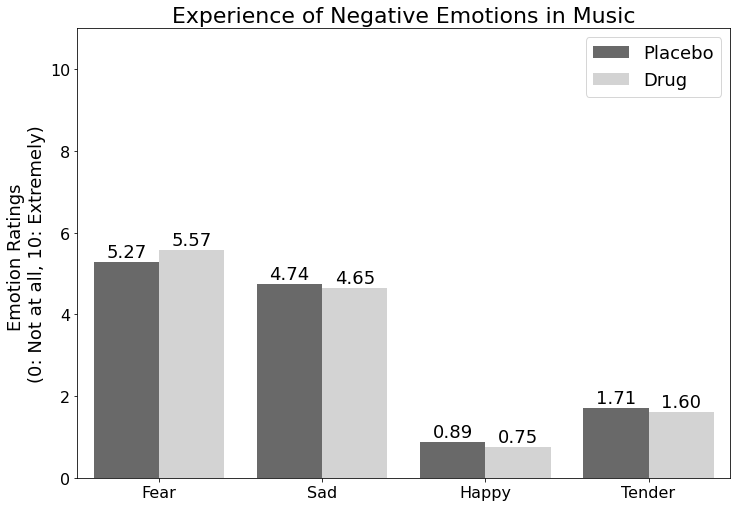

In [19]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=music, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions in Music', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Natural Sounds: Human*

In [20]:
human = natural[natural['Stimulus'].isin(['Neutral Human', 
                                             'Negative-Valence High-Arousal Human', 
                                             'Negative-Valence Low-Arousal Human', 
                                             'Positive-Valence High-Arousal Human', 
                                             'Positive-Valence Low-Arousal Human'])]

human['Stimulus'].replace("Neutral Human", "Neutral", inplace=True)
human['Stimulus'].replace("Negative-Valence High-Arousal Human", "NV-HA", inplace=True)
human['Stimulus'].replace("Negative-Valence Low-Arousal Human", "NV-LA", inplace=True)
human['Stimulus'].replace("Positive-Valence High-Arousal Human", "PV-HA", inplace=True)
human['Stimulus'].replace("Positive-Valence Low-Arousal Human", "PV-LA", inplace=True)

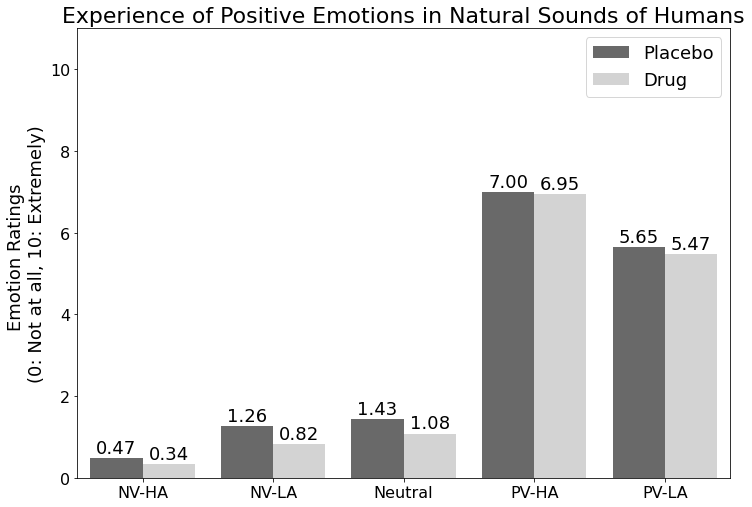

In [21]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

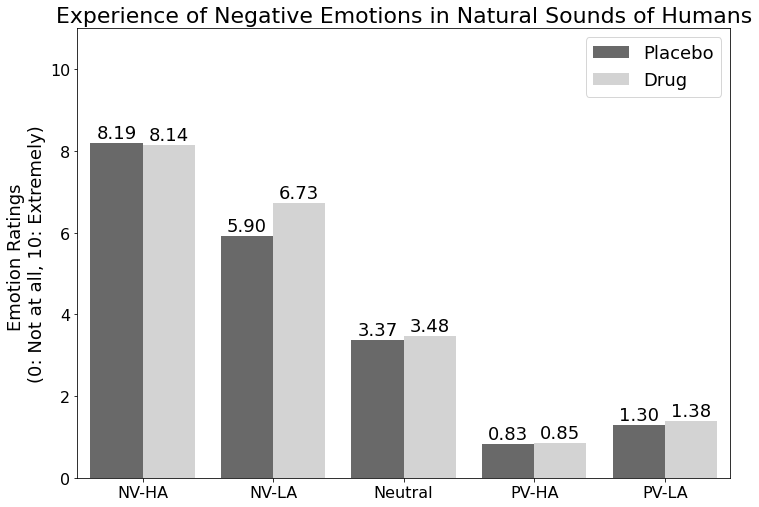

In [22]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=human, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions in Natural Sounds of Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

## *Natural Sounds: Non-Human*

In [23]:
nonhuman = natural[natural['Stimulus'].isin(['Neutral Non-human', 
                                             'Negative-Valence High-Arousal Non-human', 
                                             'Negative-Valence Low-Arousal Non-human', 
                                             'Positive-Valence High-Arousal Non-human', 
                                             'Positive-Valence Low-Arousal Non-human'])]

nonhuman['Stimulus'].replace("Neutral Non-human", "Neutral", inplace=True)
nonhuman['Stimulus'].replace("Negative-Valence High-Arousal Non-human", "NV-HA", inplace=True)
nonhuman['Stimulus'].replace("Negative-Valence Low-Arousal Non-human", "NV-LA", inplace=True)
nonhuman['Stimulus'].replace("Positive-Valence High-Arousal Non-human", "PV-HA", inplace=True)
nonhuman['Stimulus'].replace("Positive-Valence Low-Arousal Non-human", "PV-LA", inplace=True)

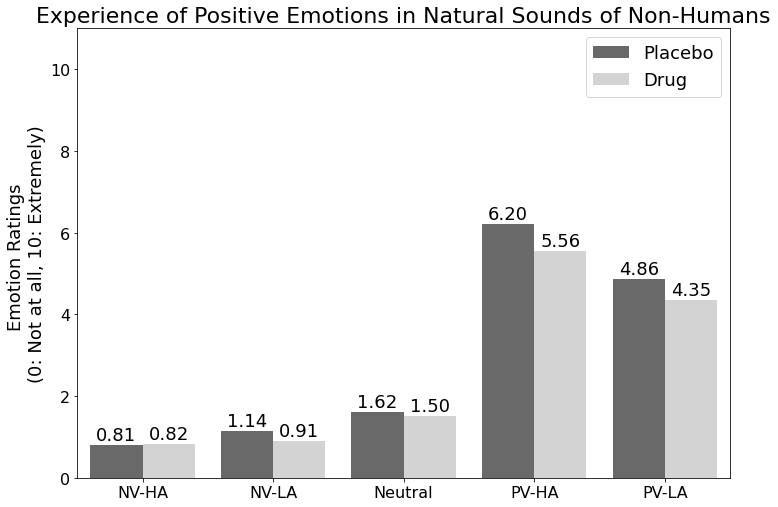

In [24]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Positive", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Positive Emotions in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

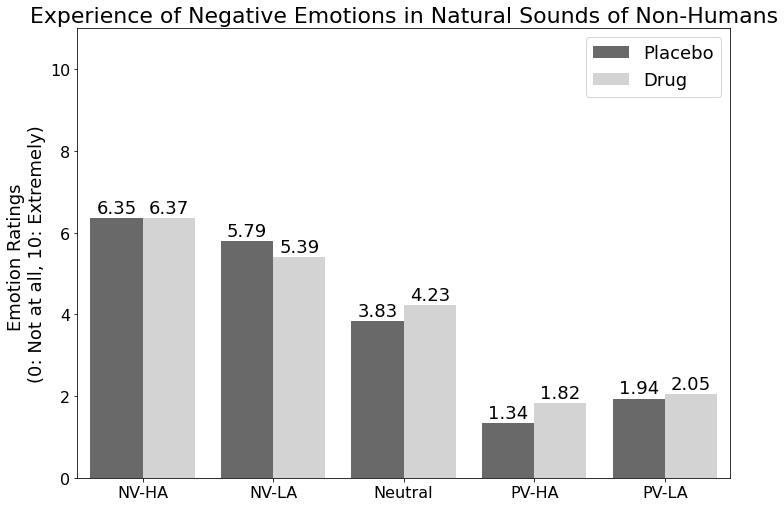

In [25]:
# dimensions
colors = ["dimgrey", "lightgrey"] # ["#9b59b6", "#3498db"]
dimensions = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dimensions)

# plot
ax = sns.barplot(x="Stimulus", y="Negative", hue="DrugPlacebo", data=nonhuman, 
                 palette=colors, ci = None)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('')
plt.ylabel('Emotion Ratings \n(0: Not at all, 10: Extremely)', fontsize = 18)
plt.ylim(0,11)
plt.title('Experience of Negative Emotions in Natural Sounds of Non-Humans', size = 22)
plt.legend(prop={'size': 18})

# annotate
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='black', xytext=(0, 10),
                textcoords='offset points')

# Summary
**There did not seem to be any significant differences in *induced* emotion ratings in drug vs. placebo conditions.**

In [26]:
# change columns back
inducedLong['DrugPlacebo'].replace("Placebo", 0, inplace=True)
inducedLong['DrugPlacebo'].replace("Drug", 1, inplace=True)
inducedLong['Russell'].replace("NV-HA", "Neg-Valence High-Arousal", inplace=True)
inducedLong['Russell'].replace("PV-HA", "Pos-Valence High-Arousal", inplace=True)
inducedLong['Russell'].replace("NV-LA", "Neg-Valence Low-Arousal", inplace=True)
inducedLong['Russell'].replace("PV-LA", "Pos-Valence Low-Arousal", inplace=True)

inducedLong.head(1)

,FixedID,DrugCode,DrugPlacebo,Locus,Stimulus,Positive,Negative,Arousal,Familiarity,Anger,Anxious,Bored,Disgusted,Excited,Fearful,Grieved,Happy,Invigorated,Joyful,Nostalgic,Peaceful,Power,Relaxed,Sad,Softhearted,Surprised,Sympathetic,Tender,Transcendent,Tension,Wonder,Neutral,PosNeg,SoundType,Russell
0,7.0,7J,0,Induced,Fear Music 1,8.0,0.0,Not Measured,1.0,0,2,0,0,1,0,0,0,1,0,0,0,2,0,0,0,1,0,0,0,2,2,0,Negative,Music,Neg-Valence High-Arousal
